In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/data/user/jbourbeau/metaprojects/icerec/V05-00-00/build/lib',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/pyth

In [2]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

import composition as comp
import composition.analysis.plotting as plotting

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
sns.set_palette('muted')
sns.set_color_codes()

In [4]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:105: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number training events = 73257


In [5]:
X_train[:50, 0], le.inverse_transform(y_train)[:50], le.inverse_transform(y_test)[:50]

(array([ 7.79736519,  7.76092207,  7.4129408 ,  7.47691717,  6.42346226,
         7.27925066,  7.74637678,  6.95309513,  6.63272187,  7.84936401,
         7.34689396,  6.90902666,  6.91576556,  7.22711222,  7.36724003,
         7.13625276,  6.86387324,  6.31386117,  7.00633715,  7.29343039,
         6.41871871,  6.26538671,  7.42050109,  7.5617521 ,  7.37776481,
         7.02361854,  7.73325344,  6.24754527,  6.56500977,  6.61578934,
         7.09462199,  7.62999252,  7.11722865,  7.69304468,  6.93698853,
         7.20570683,  6.97230993,  6.43083559,  7.79023448,  7.9675518 ,
         7.19851157,  6.50934555,  6.42590921,  7.10571311,  7.34281582,
         6.23740202,  6.36688842,  6.60754138,  7.38325199,  6.91376319]),
 array(['Fe', 'He', 'He', 'He', 'P', 'He', 'Fe', 'He', 'P', 'Fe', 'P', 'Fe',
        'He', 'P', 'He', 'P', 'He', 'He', 'He', 'He', 'He', 'He', 'He',
        'He', 'He', 'P', 'He', 'He', 'Fe', 'P', 'He', 'He', 'P', 'P', 'He',
        'P', 'P', 'P', 'He', 'Fe', 'Fe', 'F

Get error in charge vs. energy distribution

In [6]:
len(df)

104653

In [7]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
pca = PCA(n_components=2, random_state=2)
X_train_pca = pca.fit_transform(X_train_std)
X_train_pca

array([[ 2.70681815,  1.56342687],
       [ 3.12909377,  0.38618423],
       [ 2.1091339 , -0.80965787],
       ..., 
       [-2.98078972, -0.1188982 ],
       [-2.77782915, -1.21594148],
       [ 0.71343334,  1.63650409]])

In [8]:
clf = RandomForestClassifier(
            n_estimators=100, max_depth=10, n_jobs=20, random_state=2, class_weight='balanced')
param_range = np.arange(1, 31)
param_grid = {'max_depth': param_range}
gs = GridSearchCV(estimator=clf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  verbose=1,
                  n_jobs=20)
gs = gs.fit(X_train_pca, y_train)
print('best GS CV score = {}'.format(gs.best_score_))
print('best GS CV depths = {}'.format(gs.best_params_))
print('Grid scores on development set:')
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
clf.set_params(**gs.best_params_)
clf.fit(X_train_pca, y_train)
# scaler = pipeline.named_steps['scaler']
# clf = pipeline.named_steps['classifier']

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:  1.6min finished


best GS CV score = 0.442346806449
best GS CV depths = {'max_depth': 3}
Grid scores on development set:
0.277 (+/-0.001) for {'max_depth': 1}
0.422 (+/-0.017) for {'max_depth': 2}
0.442 (+/-0.010) for {'max_depth': 3}
0.434 (+/-0.028) for {'max_depth': 4}
0.410 (+/-0.011) for {'max_depth': 5}
0.398 (+/-0.010) for {'max_depth': 6}
0.391 (+/-0.012) for {'max_depth': 7}
0.395 (+/-0.009) for {'max_depth': 8}
0.394 (+/-0.007) for {'max_depth': 9}
0.398 (+/-0.009) for {'max_depth': 10}
0.404 (+/-0.009) for {'max_depth': 11}
0.407 (+/-0.014) for {'max_depth': 12}
0.409 (+/-0.011) for {'max_depth': 13}
0.413 (+/-0.010) for {'max_depth': 14}
0.418 (+/-0.010) for {'max_depth': 15}
0.423 (+/-0.014) for {'max_depth': 16}
0.426 (+/-0.009) for {'max_depth': 17}
0.427 (+/-0.008) for {'max_depth': 18}
0.430 (+/-0.011) for {'max_depth': 19}
0.432 (+/-0.010) for {'max_depth': 20}
0.433 (+/-0.008) for {'max_depth': 21}
0.434 (+/-0.007) for {'max_depth': 22}
0.434 (+/-0.007) for {'max_depth': 23}
0.436 (+/

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=20,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


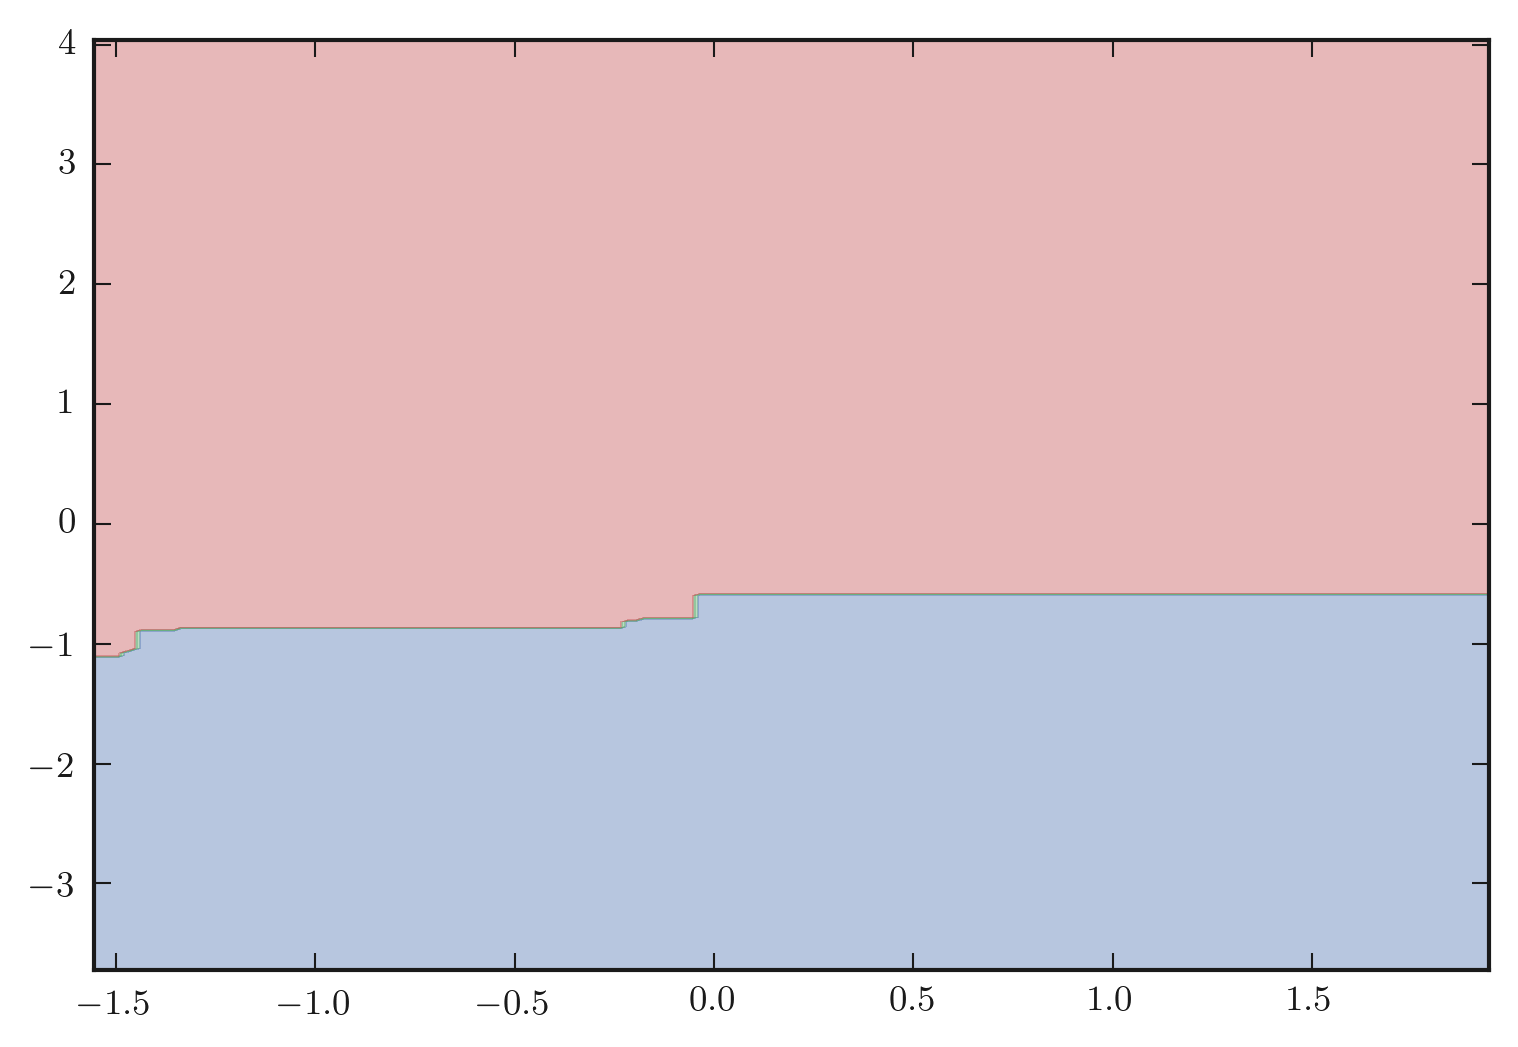

In [9]:
plotting.plot_decision_regions(X_train_std, y_train, clf, scatter_fraction=None)
plt.legend()

In [8]:
clf_name = clf.__class__.__name__
print('=' * 30)
print(clf_name)
test_predictions = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print('Test accuracy: {:.4%}'.format(test_acc))
train_predictions = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_predictions)
print('Train accuracy: {:.4%}'.format(train_acc))
scores = cross_val_score(
    estimator=pipeline, X=X_test, y=y_test, cv=10, n_jobs=10)
print('CV score: {:.2%} (+/- {:.2%})'.format(scores.mean(), scores.std()))
print('=' * 30)

RandomForestClassifier
Test accuracy: 55.9282%
Train accuracy: 99.9986%
CV score: 54.84% (+/- 0.83%)


In [9]:
comp_list = ['P', 'He', 'Fe']
# comp_list = ['P', 'Fe']
# comp_list = le.inverse_transform(np.unique(y_test))

correctly_identified_mask = (test_predictions == y_test)

# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
# energy_bins = np.arange(6.2, 9.51, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
log_energy = X_test[:, 0]

# Construct MC composition masks
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = (le.inverse_transform(y_test) == composition)

# Get number of MC comp in each reco energy bin
num_MC_energy, num_MC_energy_err = {}, {}
for composition in comp_list:
    num_MC_energy[composition] = np.histogram(log_energy[MC_comp_mask[composition]],
                                     bins=energy_bins)[0]
    num_MC_energy_err[composition] = np.sqrt(num_MC_energy[composition])

num_MC_energy['total'] = np.histogram(log_energy, bins=energy_bins)[0]
num_MC_energy_err['total'] = np.sqrt(num_MC_energy['total'])


# Get number of correctly identified comp in each reco energy bin
num_reco_energy, num_reco_energy_err = {}, {}
for composition in comp_list:
    num_reco_energy[composition] = np.histogram(
        log_energy[MC_comp_mask[composition] & correctly_identified_mask],
        bins=energy_bins)[0]
    num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

num_reco_energy['total'] = np.histogram(log_energy[correctly_identified_mask], bins=energy_bins)[0]
num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])



# Calculate correctly identified fractions as a function of MC energy
reco_frac, reco_frac_err = {}, {}
for composition in comp_list:
    print(composition)
    reco_frac[composition], reco_frac_err[composition] = comp.ratio_error(
        num_reco_energy[composition], num_reco_energy_err[composition],
        num_MC_energy[composition], num_MC_energy_err[composition])
    
reco_frac['total'], reco_frac_err['total'] = comp.ratio_error(
        num_reco_energy['total'], num_reco_energy_err['total'],
        num_MC_energy['total'], num_MC_energy_err['total'])

P
He
Fe


Training features: 
1) $\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$
2) InIce charge (top 50\%)
3) $\cos(\theta_{\mathrm{Lap}})$
4) NChannels (top 50\%)
5) $\log_{10}(S_{\mathrm{125}})$


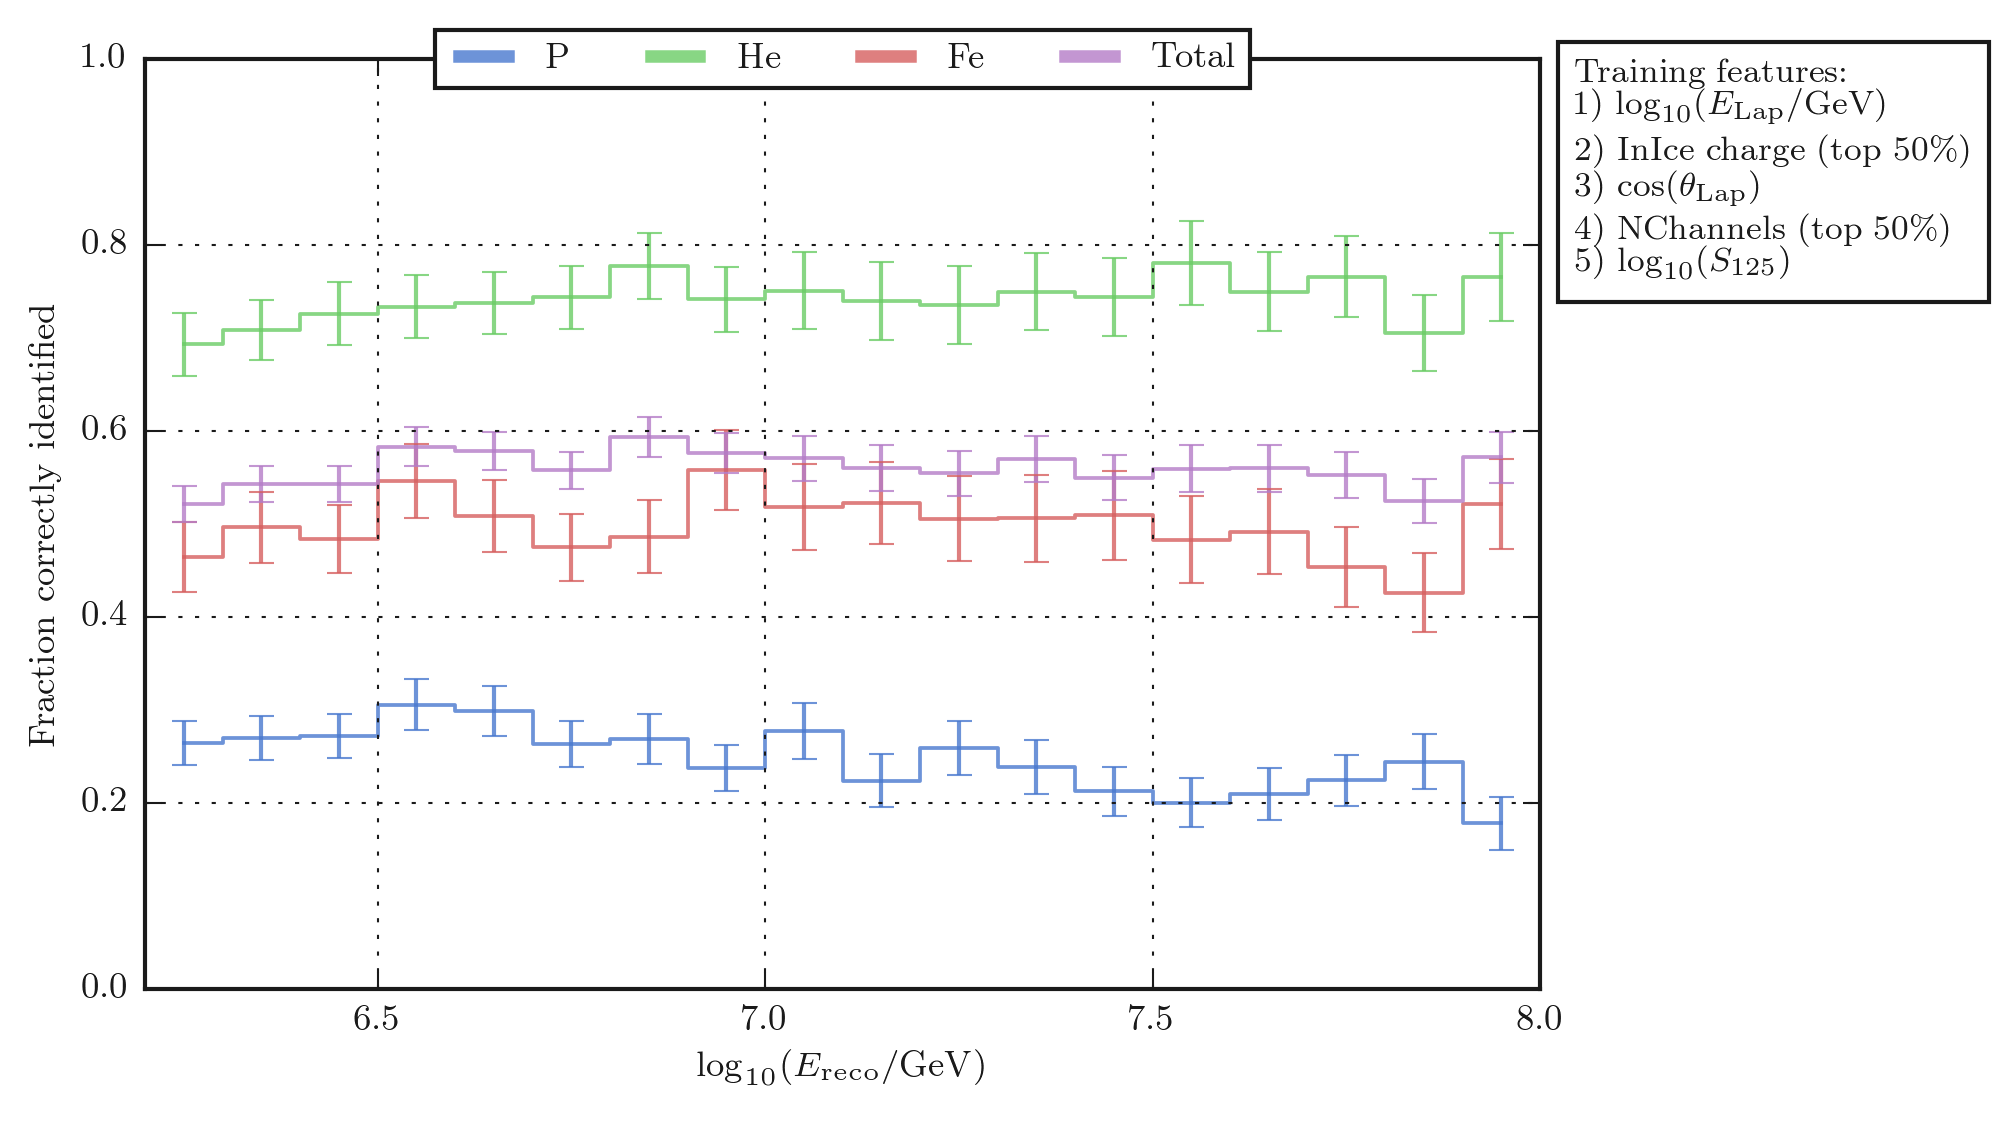

In [11]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()
for composition in comp_list:
    ebar = ax.errorbar(energy_midpoints, reco_frac[composition],
                yerr=reco_frac_err[composition],
                # xerr=energy_bin_width / 2,
                marker=None, markersize=5,
                alpha=0.8)
    ax.step(energy_midpoints, reco_frac[composition], where='mid',
            marker=None, color=ebar[0].get_color(), linewidth=0.9,
            linestyle='-', label=composition, alpha=0.8)
ebar = ax.errorbar(energy_midpoints, reco_frac['total'],
                yerr=reco_frac_err['total'],
                # xerr=energy_bin_width / 2,
                marker=None, markersize=5,
                alpha=0.8)
ax.step(energy_midpoints, reco_frac['total'], where='mid', marker=None,
        color=ebar[0].get_color(), linewidth=0.9, label='Total', alpha=0.8)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
# ax.set_xlim([6.2, 9.5])
plt.grid()
# leg = plt.legend(loc=3)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=len(comp_list)+1, fancybox=False, shadow=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
# place a text box in upper left in axes coords
textstr = 'Training features: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
print(textstr)
props = dict(facecolor='white')
# ax.text(0.0, 0.0, textstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top', bbox=props)
ax.text(1.025, 1.0, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
outfile = '/home/jbourbeau/public_html/figures/composition' + \
          '/fraction-reco-correct_vs_reco-energy_RF.png'
plt.savefig(outfile)
plt.show()

    MC Compositions
P             26297
He            53217
Fe            25156
    after
P    1911
He  23561
Fe   5929


array([<matplotlib.axes._subplots.AxesSubplot object at 0x6fa76710>], dtype=object)

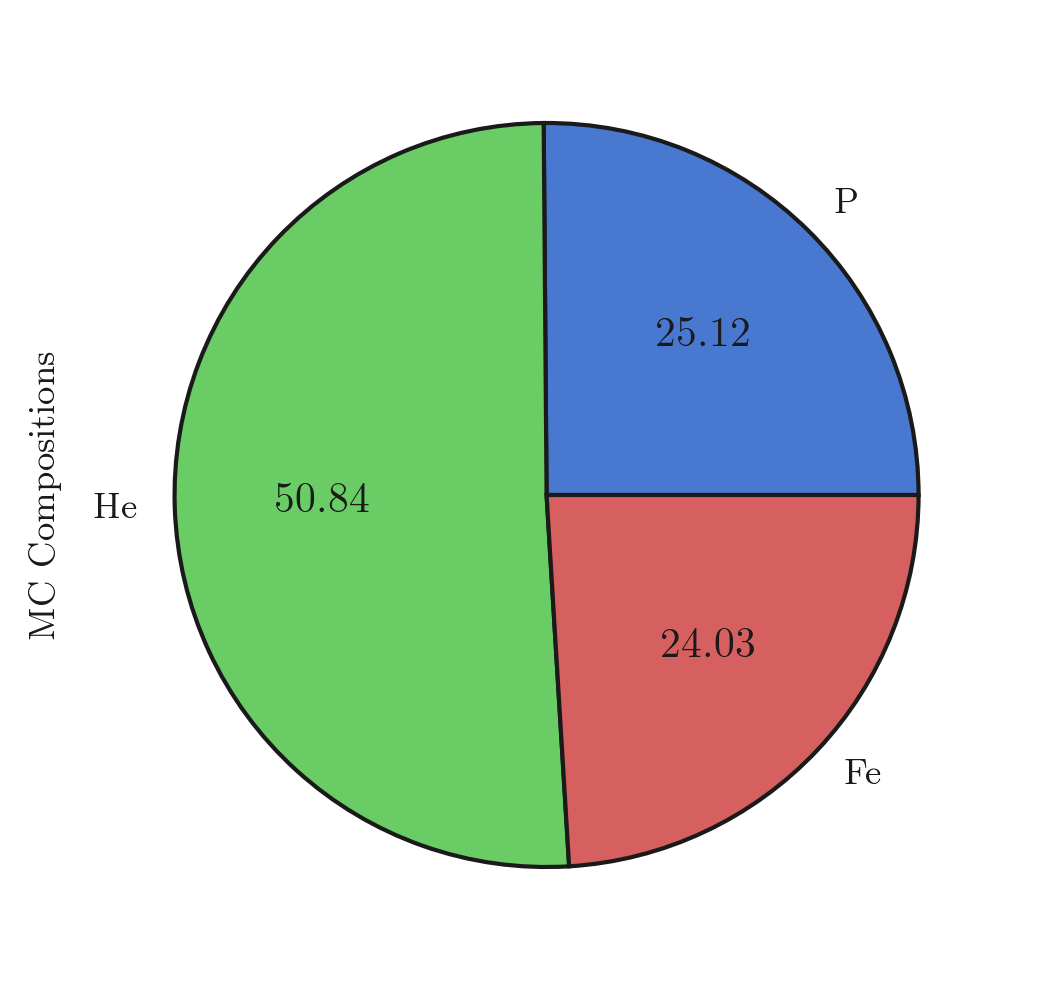

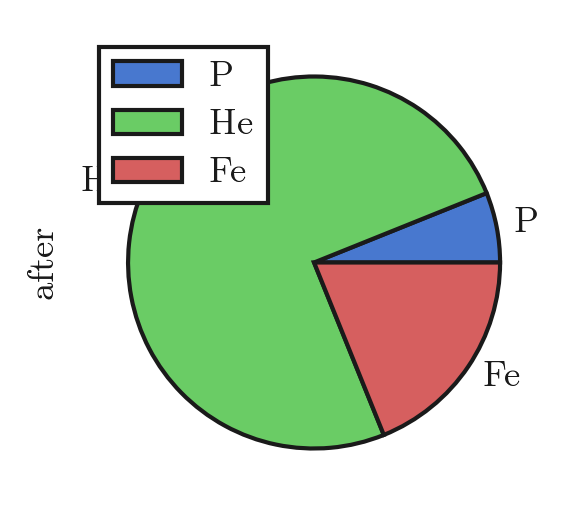

In [52]:
a = pd.DataFrame([np.sum(df.MC_comp == composition) for composition in comp_list],
                 index=comp_list, columns=['MC Compositions'])
print(a)
a.plot.pie(subplots=True, figsize=(4,4), legend=False, autopct='%.2f')
a = pd.DataFrame([np.sum(le.inverse_transform(test_predictions) == composition) for composition in comp_list], index=comp_list, columns=['after'])
print(a)
a.plot.pie(subplots=True, figsize=(2,2))

1) 0.405580146944
2) 0.191784521503
3) 0.162376146696
4) 0.135112657015
5) 0.105146527841


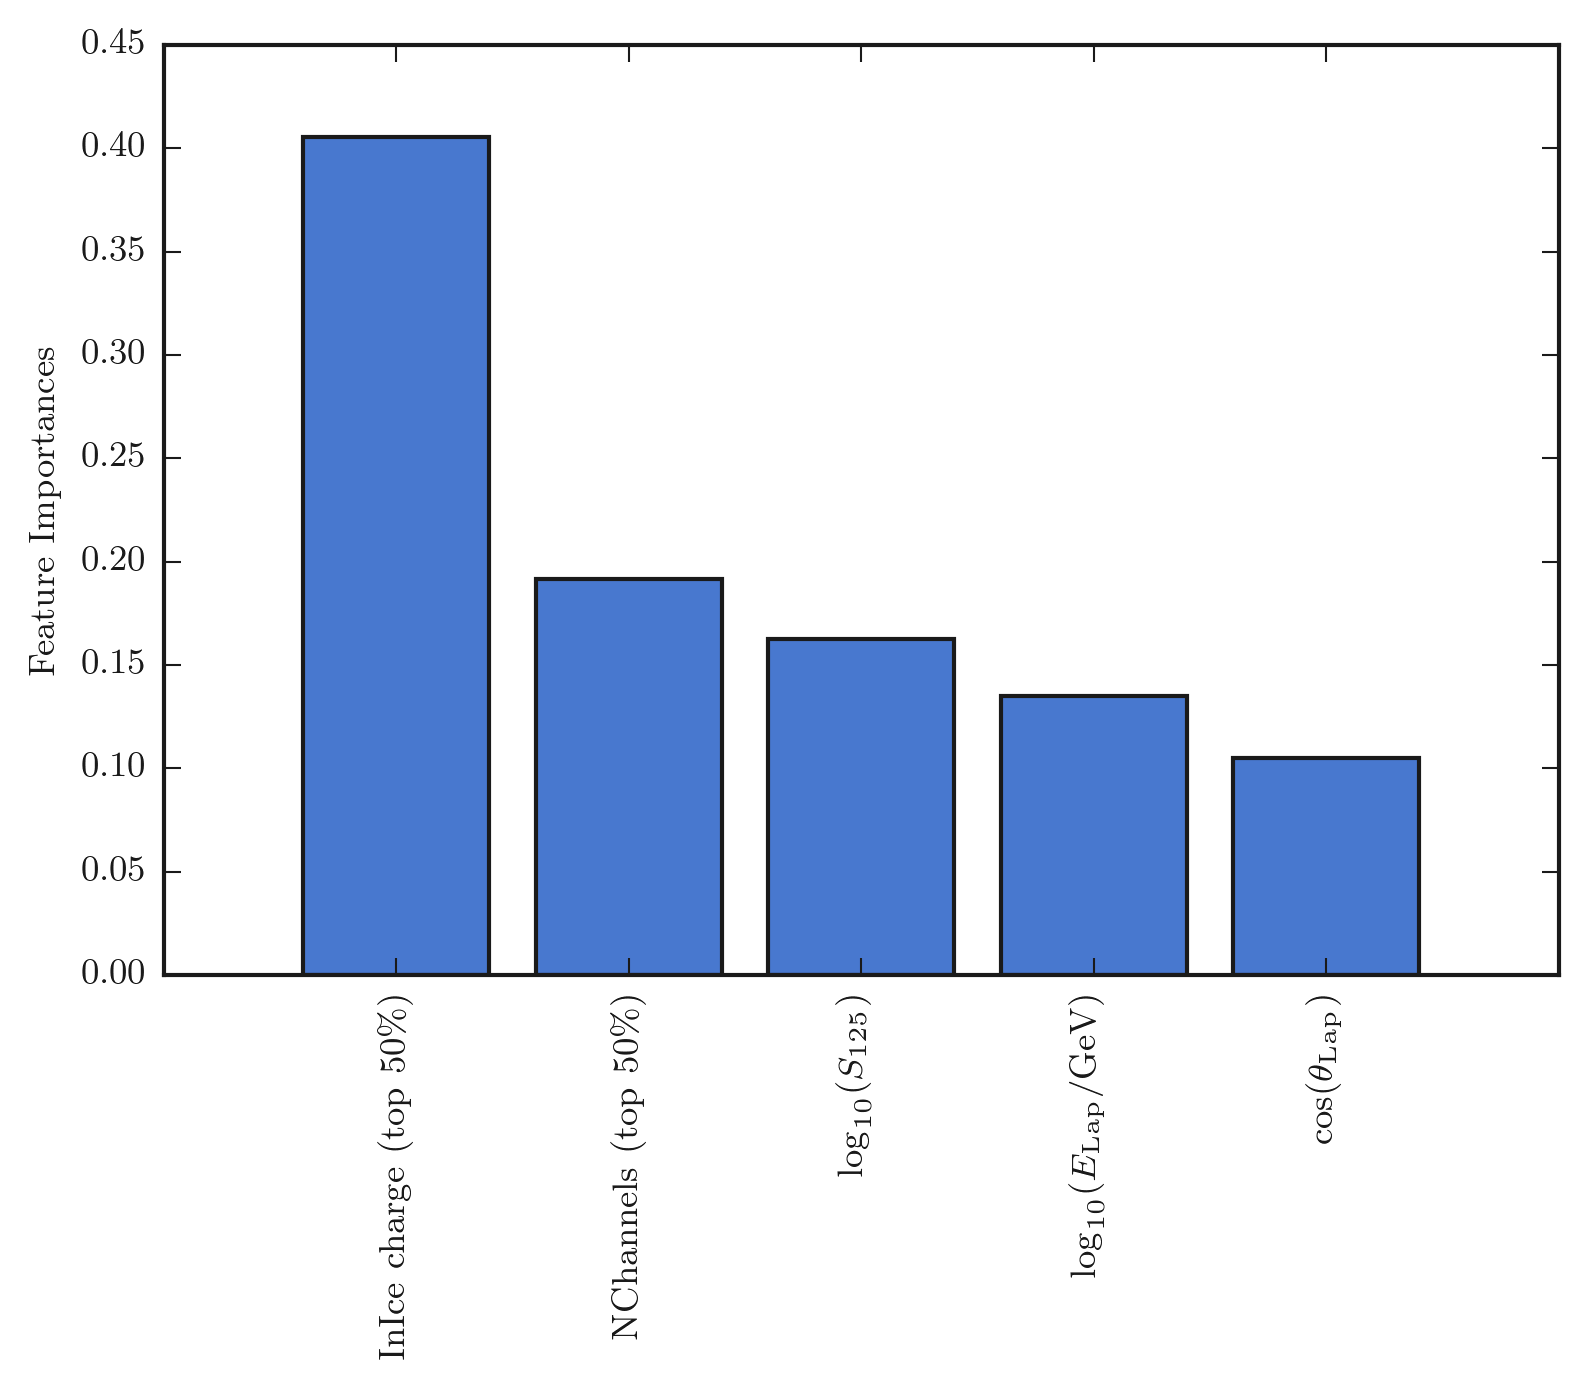

In [23]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
# feature_labels = np.array(['$\\log_{10}({\mathrm{E/GeV})$', 'InIce charge',
#                            '$\cos(\\theta)$', '$\mathrm{Laputop}\ \chi^2/\mathrm{n.d.f.}$', 'NChannels'])
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
# plt.ylim([0, .40])
plt.show()

In [50]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

NameError: name 'MC_iron_mask' is not defined

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [ ]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

In [ ]:
pipeline.named_steps['classifier'].decision_path(X_test)